# Demonstration of GeoPandas

GeoPandas is a powerful Python Package for manipulating and plotting geographical data. In this notebook we will cover:

1. GeoPandas installation
1. Creating a GeoPandas DataFrame from a standard geographic file format.
1. Setting the crs (Coordinate Reference System).
1. Creating a map from the GeoPandas DataFrame.
1. Merging geographical areas.
1. Selecting small areas within a larger area.
1. Handling point data.
1. Converting geography between BNG (British National Grid Eastings and Northings) and Latitude/Longitude.
1. Creating cusomizable maps with MatPlotLib

For areas we most commonly use shape files. The frequently come as a Zip file with the shape file and other metadata files. The repository for this notebook (https://github.com/michaelallen1966/2010_geopandas) contains all the necessary files. UK government pages to download these files tend to move around! At the time of writing the full England shape file download may be found at:

https://geoportal.statistics.gov.uk/datasets/lower-layer-super-output-areas-december-2011-boundaries-ew-bsc

## Installation

It is recommended that you install the environment as instructed in the README for this GitHub repository. You may also install packages manually ina current environment, though this method risks contability problems with your current environment. 

Alternative save the following as a file titled `environment.yml`:

```
name: geopandas
channels:
  - defaults
  - conda-forge
dependencies:
  - geopandas
  - jupyterlab
  - mapclassify
  - pip
  - python=3.8
  - pip:
    - contextily
```

Then, from the folder where that yml file is, type the following into a terminal/command line: 

`conda env create -f environment.yml`

And then activate the environment with:

`conda activate geopandas`

And then launch Jupyter Lab with:

`jupyter-lab`


## Import modules

In [1]:
import contextily as ctx
import geopandas
import matplotlib.pyplot as plt
import pandas as pd

## Load LSOA shape file

The following will load the shape file of the South West of England LSOA (Lower Super Output Areas) into a GeoPandas DataFrame. Note that we can set the crs (Coordinate Reference System) when loading a GeoPandas DataFrame. EPSG:27700 is the crs to use when geography is in BNG (British National Grid Eastings and Northings).

* EPSG:27700 OSGB 1936 / British National Grid -- United Kingdom Ordnance Survey. Co-ordinates are in Eastings (X) and Northings (Y).
* EPSG:4326 WGS 84 -- WGS84 - World Geodetic System 1984. Co-ordinates are in Longitude (X) and Latitude (Y).

This file is a manually clipped section of the South West of England. In this notebook we will restrict it to Devon and Cornwall.

In [2]:
# Import England LSAO Shape file (use 'zip://'' prefic for zip files)
filename = "zip://./data/south_west_lsoa.zip"
lsoa_gdf = geopandas.read_file(filename, crs='EPSG:27700')

A GeoPandas DataFrame has a 'geometry' column which contains the geographical details used for plotting and other geographic methos.

In [3]:
lsoa_gdf.head(3)

objectid   lsoa11cd                           lsoa11nm  \
0     13949  E01014379  Bath and North East Somerset 022A   
1     13953  E01014383  Bath and North East Somerset 021B   
2     13964  E01014394  Bath and North East Somerset 023B   

                           lsoa11nmw    st_areasha    st_lengths  \
0  Bath and North East Somerset 022A  3.562122e+07  40744.686723   
1  Bath and North East Somerset 021B  1.869634e+07  38200.007842   
2  Bath and North East Somerset 023B  7.343601e+06  20300.186471   

                                            geometry  
0  POLYGON ((371270.596 164231.895, 371284.906 16...  
1  POLYGON ((353604.188 159531.796, 353605.860 15...  
2  POLYGON ((361900.500 156839.703, 361905.406 15...

We can create a simple lot using the `plot()` method for the Geopandas DataFrame.

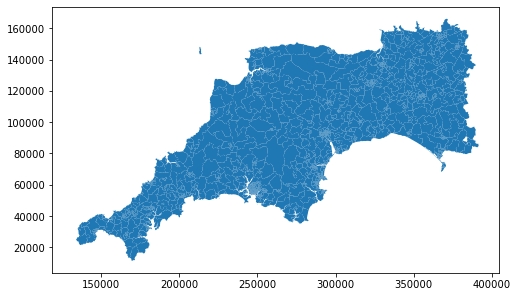

In [4]:
lsoa_gdf.plot(figsize=(8,8));

## Using Spatial Relationship methods to select data lower super output areas in Devon or Cornwall

Here we will find LSOAs that are within the counties of Devon and Cornwall.

We will start by loading a file of geography for counties and unitary authorities.

In [5]:
# Import County boundary shape file
filename = "zip://./data/Counties_and_Unitary_Authorities__December_2017" + \
    "__Boundaries_UK-shp.zip"
counties_gdf = geopandas.read_file(filename)
counties_gdf = counties_gdf.set_crs(epsg=27700)

In [6]:
filename

'zip://./data/Counties_and_Unitary_Authorities__December_2017__Boundaries_UK-shp.zip'

In [7]:
counties_gdf.head()

objectid  ctyua17cd             ctyua17nm ctyua17nmw   bng_e   bng_n  \
0         1  E06000001            Hartlepool       None  447157  531476   
1         2  E06000002         Middlesbrough       None  451141  516887   
2         3  E06000003  Redcar and Cleveland       None  464359  519597   
3         4  E06000004      Stockton-on-Tees       None  444937  518183   
4         5  E06000005            Darlington       None  428029  515649   

      long        lat    st_areasha     st_lengths  \
0 -1.27023  54.676159  9.355951e+07   71707.407523   
1 -1.21099  54.544670  5.388858e+07   43840.866561   
2 -1.00611  54.567520  2.448203e+08   97993.391012   
3 -1.30669  54.556911  2.049622e+08  119581.595543   
4 -1.56835  54.535351  1.974757e+08  107206.401694   

                                            geometry  
0  MULTIPOLYGON (((447213.900 537036.104, 447228....  
1  MULTIPOLYGON (((448958.901 521835.695, 449045....  
2  MULTIPOLYGON (((455752.600 528195.705, 455738....  
3  MULTIPOLYGON (((444157.002 527956.303, 444165....  
4  POLYGON ((423496.602 524724.298, 423497.204 52...

We can see the boundries woth the `plot()` method.

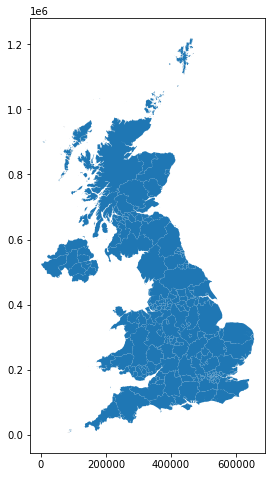

In [8]:
counties_gdf.plot(figsize=(8,8));

### Lambda functions

Take a break and watch a 6 minute video on Lambda functions:

https://youtu.be/25ovCm9jKfA

### Finding the Devon and Cornwall data

The first thing we need to do is to idenitify the rows in the DataFrame that are in Cornwall and Devon. We can't just use county names as we must also include the unitary authorities 'Plymouth' and 'Torbay'.

The best way to apply a 'by row' function in DataFrames is to use the `map()` method. This applies a given function to all rows in a DataFrame. To check whether a value is in a list we need to apply a short function. As the function is simple we can use a *lambda* function as shown below.

In [9]:
# Identify rows that are Devon or Cornwall (use Pandas map lambda function)
devon_cornwall = \
    counties_gdf['ctyua17nm'].map(
        lambda x: x in ['Devon', 'Cornwall', 'Plymouth', 'Torbay'])

In [10]:
devon_cornwall

0      False
1      False
2      False
3      False
4      False
       ...  
212    False
213    False
214    False
215    False
216    False
Name: ctyua17nm, Length: 217, dtype: bool

In [11]:
devon_cornwall.sum()

4

In [12]:
# Add new column to DataFrame. This will be a booelan (True/False) column
counties_gdf['devon_cornwall'] = devon_cornwall

In [13]:
counties_gdf.head()

objectid  ctyua17cd             ctyua17nm ctyua17nmw   bng_e   bng_n  \
0         1  E06000001            Hartlepool       None  447157  531476   
1         2  E06000002         Middlesbrough       None  451141  516887   
2         3  E06000003  Redcar and Cleveland       None  464359  519597   
3         4  E06000004      Stockton-on-Tees       None  444937  518183   
4         5  E06000005            Darlington       None  428029  515649   

      long        lat    st_areasha     st_lengths  \
0 -1.27023  54.676159  9.355951e+07   71707.407523   
1 -1.21099  54.544670  5.388858e+07   43840.866561   
2 -1.00611  54.567520  2.448203e+08   97993.391012   
3 -1.30669  54.556911  2.049622e+08  119581.595543   
4 -1.56835  54.535351  1.974757e+08  107206.401694   

                                            geometry  devon_cornwall  
0  MULTIPOLYGON (((447213.900 537036.104, 447228....           False  
1  MULTIPOLYGON (((448958.901 521835.695, 449045....           False  
2  MULTIPOLYGON (((455752.600 528195.705, 455738....           False  
3  MULTIPOLYGON (((444157.002 527956.303, 444165....           False  
4  POLYGON ((423496.602 524724.298, 423497.204 52...           False

In [14]:
mask = counties_gdf['devon_cornwall'] == True

In [15]:
dc = counties_gdf.loc[mask]

In [16]:
dc

objectid  ctyua17cd ctyua17nm ctyua17nmw   bng_e  bng_n     long  \
25         26  E06000026  Plymouth       None  249944  58255 -4.11299   
26         27  E06000027    Torbay       None  289730  64608 -3.55523   
50         51  E06000052  Cornwall       None  212501  64494 -4.64249   
129       130  E10000008     Devon       None  283141  93082 -3.65701   

           lat    st_areasha    st_lengths  \
25   50.404942  7.983013e+07  9.443270e+04   
26   50.470879  6.289084e+07  7.868016e+04   
50   50.450230  3.549501e+09  1.198962e+06   
129  50.725559  6.567162e+09  1.066744e+06   

                                              geometry  devon_cornwall  
25   MULTIPOLYGON (((250117.099 62501.498, 250152.6...            True  
26   MULTIPOLYGON (((292683.002 69724.601, 292687.8...            True  
50   MULTIPOLYGON (((226554.504 117543.003, 226683....            True  
129  MULTIPOLYGON (((275520.503 151189.002, 275522....            True

## Merging areas together

Now we are going to merge LSOAs by whetehr they are in Devon and Cornwall or not (we can merge on any column in order to combine areas). This will create a new DataFrame. To merge areas we use the `dissolve()` method.

https://geopandas.org/aggregation_with_dissolve.html

In [17]:
merged_gdf = counties_gdf.dissolve(by='devon_cornwall')
merged_gdf

geometry  objectid  \
devon_cornwall                                                                
False           MULTIPOLYGON (((83965.299 5400.503, 83966.198 ...         1   
True            MULTIPOLYGON (((132289.198 24957.995, 132286.1...        26   

                ctyua17cd   ctyua17nm ctyua17nmw   bng_e   bng_n     long  \
devon_cornwall                                                              
False           E06000001  Hartlepool   Ynys Môn  447157  531476 -1.27023   
True            E06000026    Plymouth       None  249944   58255 -4.11299   

                      lat    st_areasha    st_lengths  
devon_cornwall                                         
False           54.676159  9.355951e+07  71707.407523  
True            50.404942  7.983013e+07  94432.697411

Now we select just the geometry Devon and Cornwall row, This has an index value of 'True'.

In [18]:
dc_geometry = merged_gdf.loc[True].geometry

Jupyter will display the geometry of a single geometry zone:

In [19]:
dc_geometry

### Spatial relationships

GeoPandas can perorm a range of spacial relational test such as those shown in the figure and table below (from https://en.wikipedia.org/wiki/Spatial_relation).

![](./images/spatial_fig.png)

![](./images/spatial_table.png)



To get all LSOA in Devon or Cornwall we need to apply a test for `overlaps` or `within` (as `within` will miss those LSOA that are share a boundary with the Devon and Cornwall region. In Pandas we use `|` for `or`.

In [20]:
# Check for LSOA overlapping with, or completely within, Devon & Cornwall
mask = (lsoa_gdf.overlaps(dc_geometry)) | (lsoa_gdf.within(dc_geometry))

In [21]:
mask

0       False
1       False
2       False
3       False
4       False
        ...  
1513     True
1514     True
1515     True
1516     True
1517     True
Length: 1518, dtype: bool

In [22]:
# Create new Geopands DataFrame by applying mask
devon_cornwall_lsoa = lsoa_gdf.loc[mask]

In [23]:
devon_cornwall_lsoa.head()

objectid   lsoa11cd       lsoa11nm      lsoa11nmw     st_areasha  \
32     14568  E01015023  Plymouth 003A  Plymouth 003A  914900.802386   
33     14569  E01015024  Plymouth 004A  Plymouth 004A  399214.790350   
34     14570  E01015025  Plymouth 001A  Plymouth 001A  760223.599354   
35     14571  E01015026  Plymouth 003B  Plymouth 003B  238427.363864   
36     14572  E01015027  Plymouth 002A  Plymouth 002A  677905.679684   

     st_lengths                                           geometry  
32  7363.070724  POLYGON ((247788.610 59512.254, 247776.924 595...  
33  4006.004562  POLYGON ((246131.912 60161.766, 246123.400 601...  
34  5173.608763  POLYGON ((249720.786 60435.671, 249723.156 604...  
35  3158.258430  POLYGON ((246619.768 59899.601, 246612.380 599...  
36  5478.328714  POLYGON ((248897.144 59938.602, 248879.899 599...

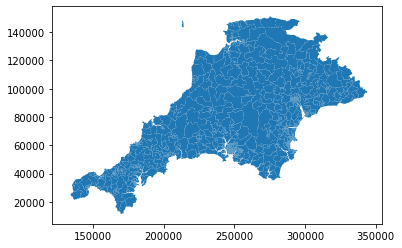

In [24]:
# Show map of new DataFrame
devon_cornwall_lsoa.plot();

## Loading point data (hospitals) and selecting those in Devon and Cornwall.

We will load up a CSV file with hospital (acute stroke unit) data and create a geometry column from exisiting location data. This time our location data uses  Longitude and Latitute. For this we will use a different crs, namely EPSG:4326 (alo known as WGS84). This is a global reference system for Long/Lat. We will demonstrate an alternative way of setting crs, setting it *after* we have created the GeoPandas DataFrame. 

In [25]:
# Load hospital data in GeoPandas DataFrame
hospitals_gdf = geopandas.read_file('./data/hosp_107.csv')
# Set geometry (note longitude comes first as GeoPandas expects x/y geometry)
hospitals_gdf.geometry = geopandas.points_from_xy(
        hospitals_gdf.long, hospitals_gdf.lat)
# Set crs for geometry, using epsg4326 for lat/long
hospitals_gdf = hospitals_gdf.set_crs(epsg=4326)
hospitals_gdf.head()

hospital               lat                long Strategic Clinical Network  \
0   RM70AG  51.5686204781614            0.179031                 London SCN   
1    E11BB   51.519024600693  -0.058075031814056                 London SCN   
2   SW66SX  51.4737150883794  -0.212721758225151                 London SCN   
3   SE59RW  51.4695040169144  -0.093251532341465                 London SCN   
4   BR68ND         51.366243            0.059146                 London SCN   

                                     Stroke Team Local  \
0                      Queen's Hospital, Romford     0   
1                      The Royal London Hospital     0   
2                 Charing Cross Hospital, London     0   
3                King's College Hospital, London     0   
4  Princess Royal University Hospital; Orpington     0   

                    geometry  
0   POINT (0.17903 51.56862)  
1  POINT (-0.05808 51.51902)  
2  POINT (-0.21272 51.47372)  
3  POINT (-0.09325 51.46950)  
4   POINT (0.05915 51.36624)

We now convert crs from Lat/long to the BNG (EPSG 27700) we have been using in the LSOA DataFrame.

In [26]:
hospitals_gdf = hospitals_gdf.to_crs(epsg=27700)

Notice how the geometry column has changed:

In [27]:
hospitals_gdf.head()

hospital               lat                long Strategic Clinical Network  \
0   RM70AG  51.5686204781614            0.179031                 London SCN   
1    E11BB   51.519024600693  -0.058075031814056                 London SCN   
2   SW66SX  51.4737150883794  -0.212721758225151                 London SCN   
3   SE59RW  51.4695040169144  -0.093251532341465                 London SCN   
4   BR68ND         51.366243            0.059146                 London SCN   

                                     Stroke Team Local  \
0                      Queen's Hospital, Romford     0   
1                      The Royal London Hospital     0   
2                 Charing Cross Hospital, London     0   
3                King's College Hospital, London     0   
4  Princess Royal University Hospital; Orpington     0   

                        geometry  
0  POINT (551118.112 187777.101)  
1  POINT (534833.002 181798.858)  
2  POINT (524227.002 176486.858)  
3  POINT (532536.002 176227.858)  
4  POINT (543442.972 165031.953)

Identify hospitals `within` the Devon and Cornwall geometry zone we created earlier.

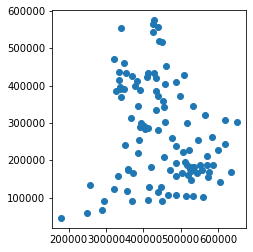

In [28]:
hospitals_gdf.plot();

In [29]:
mask = hospitals_gdf.within(dc_geometry)
dc_hospitals = hospitals_gdf.loc[mask]
dc_hospitals

hospital               lat               long Strategic Clinical Network  \
86  EX314JB  51.0922001006618          -4.050431             South West SCN   
87   PL68DH  50.4167185395317  -4.11368451019577             South West SCN   
88   TR13LQ         50.266557          -5.094263             South West SCN   
89   EX25DW  50.7167104552595  -3.50668010107328             South West SCN   
93   TQ27AA  50.4823238915546  -3.55379010251807             South West SCN   

                                  Stroke Team Local  \
86  North Devon District Hospital, Barnstaple     1   
87               Derriford Hospital, Plymouth     1   
88             Royal Cornwall Hospital, Truro     1   
89            Royal Devon and Exeter Hospital     1   
93                            Torbay Hospital     1   

                         geometry  
86  POINT (256506.124 134543.483)  
87   POINT (249929.994 59563.843)  
88   POINT (179580.970 45312.946)  
89   POINT (293729.995 91869.847)  
93   POINT (289857.995 65876.844)

## Bring in travel times to closest hospital

We will load data on travel times from each LSOA to their closest acute stroke unit. The DataFrame `merge` method is used to merge this into our GeoPandas DataFrame.

In [30]:
# Import table of travel times from LSOA to closest stroke unit
travel_time = pd.read_csv('./data/lsoa_107_ivt.csv')

In [31]:
travel_time.head()

area  admissions  time_to_thrombolysis_unit  IVT_unit_#  \
0  Welwyn Hatfield 010F    0.666667                  17.666667          19   
1  Welwyn Hatfield 012A    4.000000                  20.716667          19   
2  Welwyn Hatfield 002F    2.000000                  18.816667          19   
3  Welwyn Hatfield 002E    0.666667                  19.000000          19   
4  Welwyn Hatfield 010A    3.333333                  17.700000          19   

   time_to_thrombectomy_unit  ET_unit_#  Add_benefit_per_1000  index_#_x  \
0                 116.666667         17             18.861646         19   
1                 119.716667         17             18.631853         19   
2                 117.816667         17             18.774986         19   
3                 118.000000         17             18.761172         19   
4                 116.700000         17             18.859134         19   

  IVT unit  index_#_y ET unit  IVT_rate  Adjusted_benefit  
0   SG14AB         17  CB20QQ      11.0         10.373906  
1   SG14AB         17  CB20QQ      11.0         10.247519  
2   SG14AB         17  CB20QQ      11.0         10.326242  
3   SG14AB         17  CB20QQ      11.0         10.318645  
4   SG14AB         17  CB20QQ      11.0         10.372524

In [32]:
# Merge data
devon_cornwall_lsoa = devon_cornwall_lsoa.merge(
    travel_time, left_on='lsoa11nm', right_on='area', how='left')

In [33]:
devon_cornwall_lsoa.head()

objectid   lsoa11cd       lsoa11nm      lsoa11nmw     st_areasha  \
0     14568  E01015023  Plymouth 003A  Plymouth 003A  914900.802386   
1     14569  E01015024  Plymouth 004A  Plymouth 004A  399214.790350   
2     14570  E01015025  Plymouth 001A  Plymouth 001A  760223.599354   
3     14571  E01015026  Plymouth 003B  Plymouth 003B  238427.363864   
4     14572  E01015027  Plymouth 002A  Plymouth 002A  677905.679684   

    st_lengths                                           geometry  \
0  7363.070724  POLYGON ((247788.610 59512.254, 247776.924 595...   
1  4006.004562  POLYGON ((246131.912 60161.766, 246123.400 601...   
2  5173.608763  POLYGON ((249720.786 60435.671, 249723.156 604...   
3  3158.258430  POLYGON ((246619.768 59899.601, 246612.380 599...   
4  5478.328714  POLYGON ((248897.144 59938.602, 248879.899 599...   

            area  admissions  time_to_thrombolysis_unit  IVT_unit_#  \
0  Plymouth 003A    2.666667                   9.583333         104   
1  Plymouth 004A    0.000000                  10.450000         104   
2  Plymouth 001A    1.666667                   5.433333         104   
3  Plymouth 003B    0.666667                   9.616667         104   
4  Plymouth 002A    1.666667                   5.683333         104   

   time_to_thrombectomy_unit  ET_unit_#  Add_benefit_per_1000  index_#_x  \
0                   9.583333        104             19.471349        104   
1                  10.450000        104             19.405932        104   
2                   5.433333        104             19.784748        104   
3                   9.616667        104             19.468833        104   
4                   5.683333        104             19.765862        104   

  IVT unit  index_#_y ET unit  IVT_rate  Adjusted_benefit  
0   PL68DH        104  PL68DH       9.1          8.859464  
1   PL68DH        104  PL68DH       9.1          8.829699  
2   PL68DH        104  PL68DH       9.1          9.002060  
3   PL68DH        104  PL68DH       9.1          8.858319  
4   PL68DH        104  PL68DH       9.1          8.993467

## Mapping data with MatPlotLib

Using MatPlotLib gives us mreo power than the GeoPandas DataFrame `plot` method.

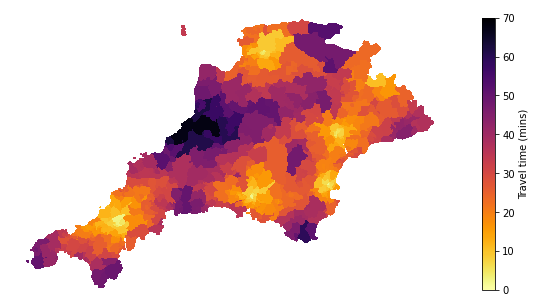

In [34]:
fig, ax = plt.subplots(figsize=(10, 10)) # Make max dimensions 10x10 inch
devon_cornwall_lsoa.plot(ax=ax, # Set which axes to use for plot (only one here)
                 column='time_to_thrombolysis_unit', # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 vmin=0, # Manual scale min (remove to make automatic)
                 vmax=70, # Manual scale max (remove to make automatic)
                 cmap='inferno_r', # Colour map to use
                 # Adjust size of colourmap key, and add label
                 legend_kwds={'shrink':0.5, 'label':'Travel time (mins)'},
                 # Set to display legend
                 legend=True)
ax.set_axis_off() # Turn of axis linea dn numbers
plt.savefig('map.jpg', dpi=300) # Save figure
plt.show()

Repeat, but display hospitals as an extra plot using `ax` as axis. We will add hospital name (just postcode here), and use contexity to add a base map.

In [35]:
# When using base maps convert data to epsg:3857
devon_cornwall_lsoa = devon_cornwall_lsoa.to_crs(epsg=3857)
dc_hospitals = dc_hospitals.to_crs(epsg=3857)

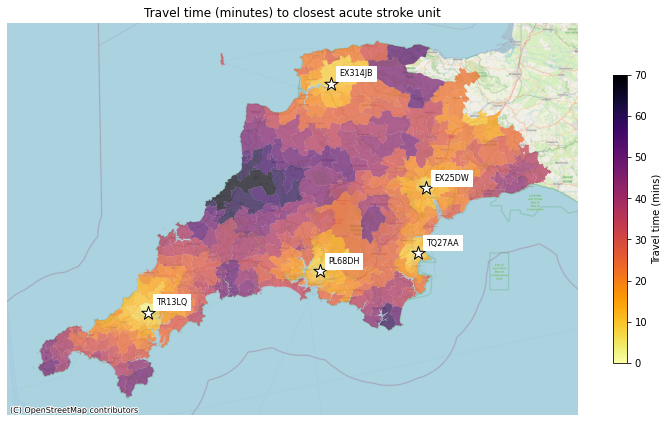

In [36]:
fig, ax = plt.subplots(figsize=(10, 10)) # Make max dimensions 10x10 inch
# Plot travel times for each LSOA
devon_cornwall_lsoa.plot(ax=ax, # Set which axes to use for plot (only one here)
        column='time_to_thrombolysis_unit', # Column to apply colour
        # antialiased=False, # Avoids artifact boundry lines
        edgecolor='face', # Make LSOA boundry same colour as area
        linewidth=0.0,# Use linewidth=0 to hide boarder lines
        vmin=0, # Manual scale min (remove to make automatic)
        vmax=70, # Manual scale max (remove to make automatic)
        cmap='inferno_r', # Coloour map to use
        # Adjust size of colourmap key, and add label
        legend_kwds={'shrink':0.4, 'label':'Travel time (mins)'},
        # Set to display legend
        legend=True,
        # Set transparancy (to help reveal basemap)
        alpha = 0.70)

# Plot location of hospitals
dc_hospitals.plot(ax=ax, edgecolor='k', facecolor='w', markersize=200, 
                  marker='*')
# Add labels
for x, y, label in zip(
    dc_hospitals.geometry.x, dc_hospitals.geometry.y, dc_hospitals.hospital):
        ax.annotate(label, xy=(x, y), xytext=(8, 8), textcoords="offset points",
                    backgroundcolor="w", fontsize=8)
        
# Add base map (note that we specifiy thr same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)
    
ax.set_axis_off() # Turn of axis line numbers
ax.set_title('Travel time (minutes) to closest acute stroke unit')
# Adjust for printing
ax.margins(0)
ax.apply_aspect()
plt.subplots_adjust(left=0.01, right=1.0, bottom=0.0, top=1.0)
# Save figure
plt.savefig('map.jpg', dpi=300)
plt.show()